In [5]:
## Init ##
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from rdkit import Chem
import sys

sys.path.insert(1, '/scion/')
import scion.data_analysis as danal

fname = os.path.join(os.getcwd(), r'data/SupportingData.xlsx')
savepath = os.path.join(os.getcwd(), 'images')
avgs_path = os.path.join(os.getcwd(), 'data/pca/avgs.npy')

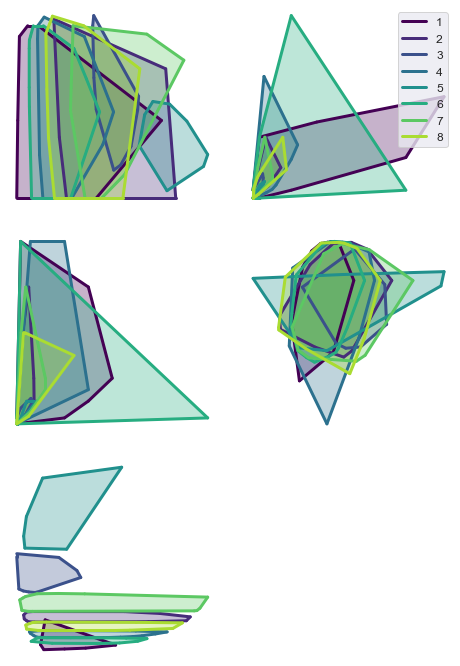

In [2]:
## Plot ChemSpace clusters, variables ##
cs_data_pca = pd.read_excel(fname, sheet_name='ChemSpace')
cols = ['Mass', 'N/C', 'N/H', 'O/C', 'O/H', 'logP', 'pKa (most acidic)',
        'Balaban Index', 'Harary Index', 'Ring Bond %']
data_vars = cs_data_pca[cols].values

# Where nans present, replace with avg. (same as done pre-PCA)
avgs = np.load(avgs_path)
for i in range(data_vars.shape[1]):
    data_vars[np.isnan(data_vars[:, i]), i] = avgs[i]

# For better var pairing in figure
reorder = [0, 9, 1, 2, 3, 4, 5, 6, 7, 8]
data_vars = data_vars[:, reorder]
cols = [cols[i] for i in reorder]

filename = os.path.join(savepath, 'ChemSpace_Vars')
danal.plot_vars(data_vars, cols, cs_data_pca['ChemSpace Cluster'].tolist(),
                filename=filename)

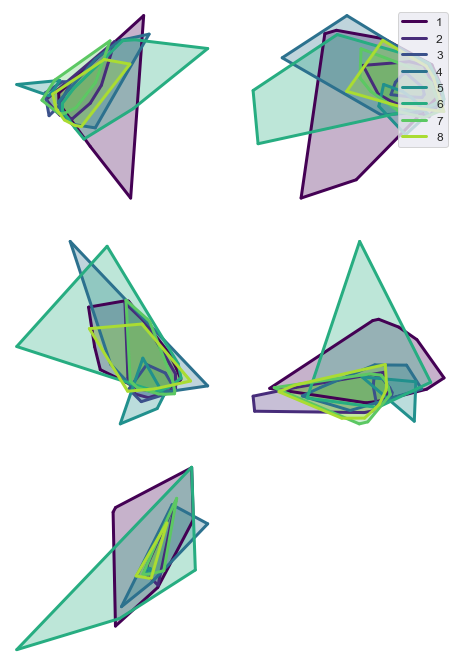

In [3]:
## Plot ChemSpace clusters, PCs ##
pca_cols = ['PC%i' % (i + 1) for i in range(len(cols))]
filename = os.path.join(savepath, 'ChemSpace_PCA')
danal.plot_vars(cs_data_pca[pca_cols].values, pca_cols,
                cs_data_pca['ChemSpace Cluster'].tolist(), filename=filename)

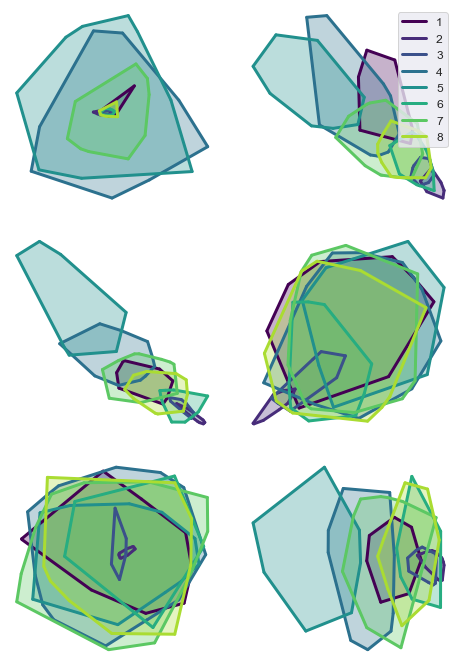

In [4]:
## Plot DarkChem clusters ##
dc_data = pd.read_excel(fname, sheet_name='DarkChem')
ls_cols = ['LS%i' % (i + 1) for i in range(12)]
filename = os.path.join(savepath, 'DarkChem_LS')
danal.plot_vars(dc_data[ls_cols].values, ls_cols,
                dc_data['DarkChem Cluster'].tolist(), filename=filename)

In [6]:
## Data prep for ionization results ##

# Create dfs for each condition (spiked in, observed, not observed)
obs, not_obs, spiked = danal.get_spiked_results(fname)

# Create dfs with chemspace properties
labels = danal.get_cpd_labels(fname)
cols = ['CpdInd', 'Mass', 'N/C', 'N/H', 'O/C', 'O/H', 'logP', 'pKa (most acidic)',
        'Balaban Index', 'Harary Index', 'Ring Bond %']
cs_data = pd.read_excel(fname, sheet_name='ChemSpace', usecols=cols)
cs_data_all = cs_data.join(labels.set_index('CpdInd'), on='CpdInd')
cs_data_obs = obs.join(cs_data.set_index('CpdInd'), on='CpdInd')
cs_data_notobs = not_obs.join(cs_data.set_index('CpdInd'), on='CpdInd')
cs_data_spiked = spiked.join(cs_data.set_index('CpdInd'), on='CpdInd')

# Unique labels
uniq_labels_cf = cs_data_all['ClassyFire Superclass'].unique()
uniq_labels_cs = cs_data_all['ChemSpace Cluster'].unique()
uniq_labels_dc = cs_data_all['DarkChem Cluster'].unique()
uniq_labels_ss = cs_data_all['Substructure Cluster'].unique()

# Get counts
cf_spiked = danal.get_counts(spiked, 'ClassyFire Superclass', uniq_labels_cf)
cs_spiked = danal.get_counts(spiked, 'ChemSpace Cluster', uniq_labels_cs)
dc_spiked = danal.get_counts(spiked, 'DarkChem Cluster', uniq_labels_dc)
ss_spiked = danal.get_counts(spiked, 'Substructure Cluster', uniq_labels_ss)

cf_obs = danal.get_counts(obs, 'ClassyFire Superclass', uniq_labels_cf)
cs_obs = danal.get_counts(obs, 'ChemSpace Cluster', uniq_labels_cs)
dc_obs = danal.get_counts(obs, 'DarkChem Cluster', uniq_labels_dc)
ss_obs = danal.get_counts(obs, 'Substructure Cluster', uniq_labels_ss)

cf_notobs = danal.get_counts(not_obs, 'ClassyFire Superclass', uniq_labels_cf)
cs_notobs = danal.get_counts(not_obs, 'ChemSpace Cluster', uniq_labels_cs)
dc_notobs = danal.get_counts(not_obs, 'DarkChem Cluster', uniq_labels_dc)
ss_notobs = danal.get_counts(not_obs, 'Substructure Cluster', uniq_labels_ss)

cf_fulllib = danal.get_counts(cs_data_all, 'ClassyFire Superclass', uniq_labels_cf)
cs_fulllib = danal.get_counts(cs_data_all, 'ChemSpace Cluster', uniq_labels_cs)
dc_fulllib = danal.get_counts(cs_data_all, 'DarkChem Cluster', uniq_labels_dc)
ss_fulllib = danal.get_counts(cs_data_all, 'Substructure Cluster', uniq_labels_ss)

# Get totals by method
cf_obs_method = danal.get_method_counts(obs, 'ClassyFire Superclass')
cs_obs_method = danal.get_method_counts(obs, 'ChemSpace Cluster')
dc_obs_method = danal.get_method_counts(obs, 'DarkChem Cluster')
ss_obs_method = danal.get_method_counts(obs, 'Substructure Cluster')

C:\Users\MontyPypi\Google Drive\Jamie Nunez PNNL\Papers\2020_Nunez_2WENTACT\pnnl_repo\scion\data_analysis.py:118: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  res.set_value(label, 0)


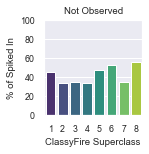

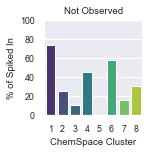

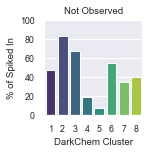

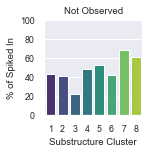

In [6]:
## Not observed compounds for each group/cluster, out of all spiked in compounds ##
datasets = [cf_notobs / cf_spiked, cs_notobs / cs_spiked, dc_notobs / dc_spiked,
            ss_notobs / ss_spiked]
names = ['cf', 'clust', 'dc', 'ss']
for data, name in zip(datasets, names):
    filename = os.path.join(savepath, 'barplots/barplot_notobs_%s' % name)
    danal.plot_bar_percent(data * 100, '% of Spiked In', title='Not Observed',
                           filename=filename)

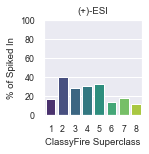

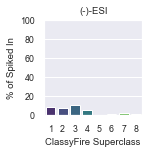

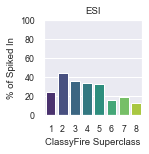

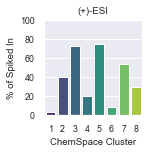

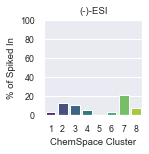

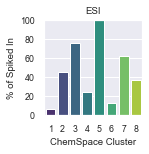

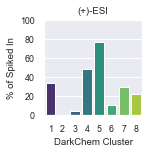

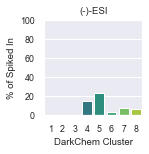

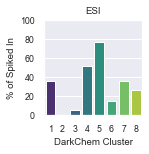

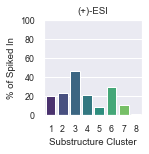

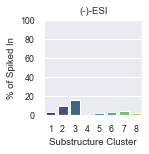

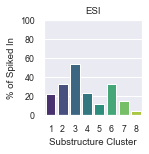

In [7]:
## Observed compounds for each group/cluster, sorted by method, out of all spiked in compounds ##
datasets = [cf_obs_method, cs_obs_method, dc_obs_method, ss_obs_method]

totals = [cf_spiked, cs_spiked, dc_spiked, ss_spiked]
ylabel = '% of Spiked In'
names = ['cf', 'cs', 'dc', 'ss']
filename = os.path.join(savepath, 'barplots/barplot_%s_%s')
danal.plot_bars_percent_method(datasets, totals, ylabel, names,
                               filename=filename)

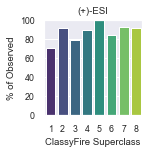

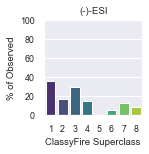

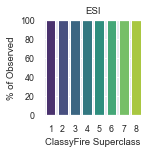

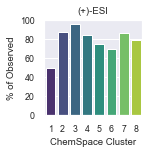

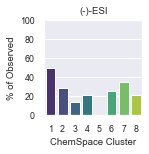

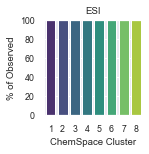

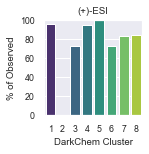

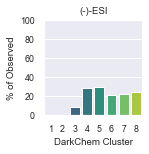

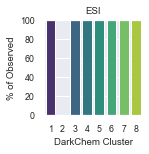

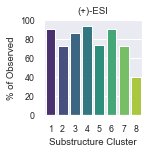

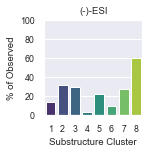

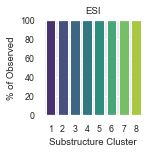

In [8]:
## Observed compounds for each group/cluster, sorted by method, out of all observed compounds ##
totals = [cf_obs, cs_obs, dc_obs, ss_obs]; ylabel = '% of Observed'
names = ['cf_percent', 'cs_percent', 'dc_percent', 'ss_percent']
filename = os.path.join(savepath, 'barplots/barplot_%s_%s')
danal.plot_bars_percent_method(datasets, totals, ylabel, names,
                               filename=filename)

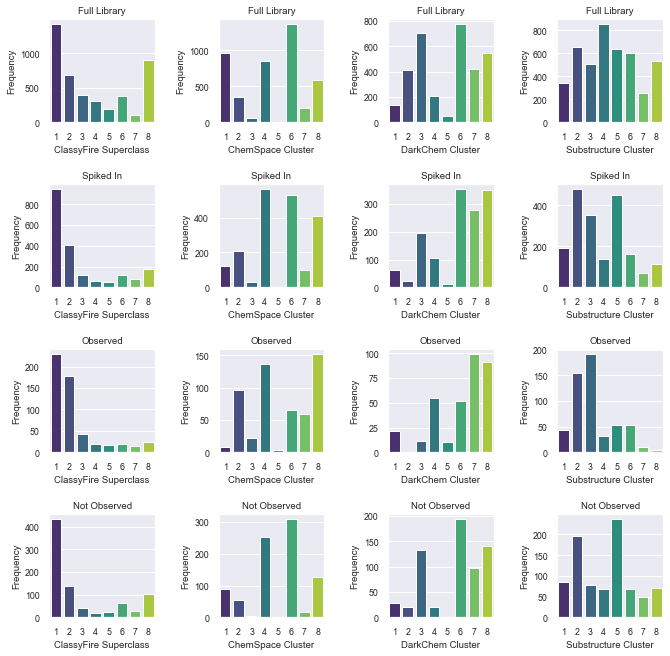

In [9]:
## Counts for number of members in each group/cluster ##
datasets = [cf_fulllib, cs_fulllib, dc_fulllib, ss_fulllib,
            cf_spiked, cs_spiked, dc_spiked, ss_spiked,
            cf_obs, cs_obs, dc_obs, ss_obs,
            cf_notobs, cs_notobs, dc_notobs, ss_notobs]
titles = ['Full Library', 'Full Library', 'Full Library', 'Full Library',
          'Spiked In', 'Spiked In', 'Spiked In', 'Spiked In',
          'Observed', 'Observed', 'Observed', 'Observed',
          'Not Observed', 'Not Observed', 'Not Observed', 'Not Observed']
filename = os.path.join(savepath, 'barplot_counts')
danal.plot_bar_counts_multi(datasets, 'Frequency', titles, ymax=None,
                            filename=filename)

ClassyFire Superclass


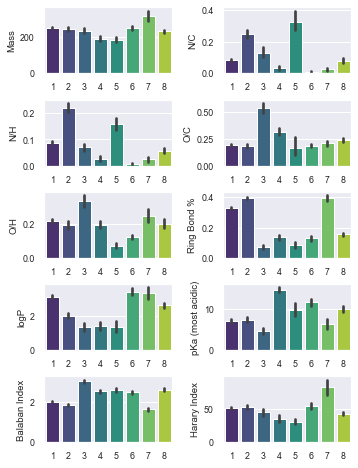

ChemSpace Cluster


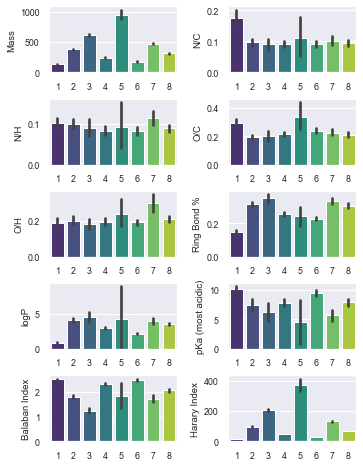

DarkChem Cluster


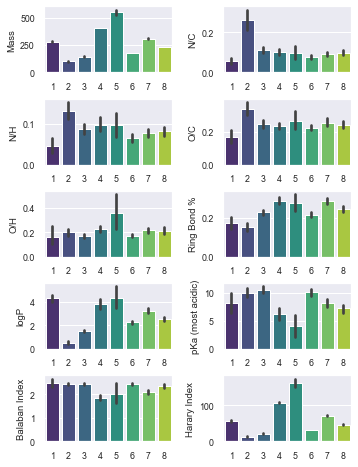

Substructure Cluster


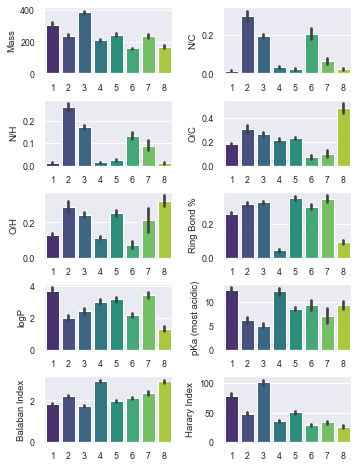

In [10]:
## Properties for spiked in/observed/not observed, by group.cluster ##
title = 'Full Library'
data = cs_data_all

for label in list(labels)[1:]:
    print(label)
    data.sort_values(label, inplace=True)
    filename = os.path.join(savepath, 'properties_%s_%s' % (label, title))
    filename = filename.replace(' ', '')
    danal.plot_bar_averages_multi(label, list(cs_data)[1:], data, cols=2, rows=5,
                                  fig_width=5.5, filename=filename)

ClassyFire Superclass


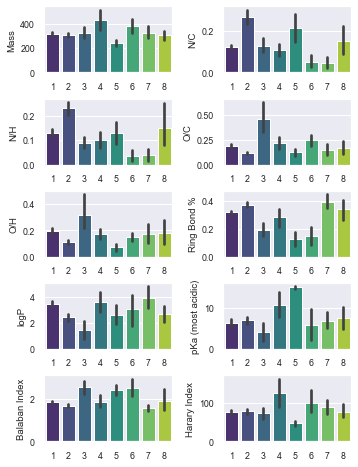

ChemSpace Cluster


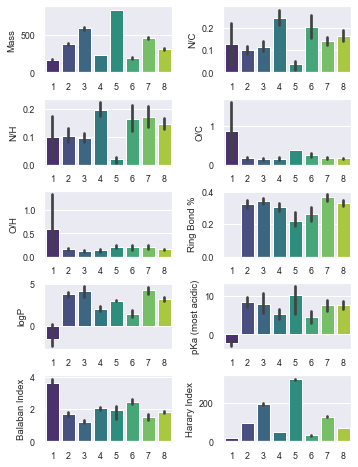

DarkChem Cluster


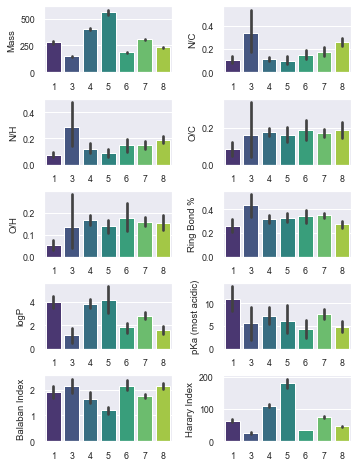

Substructure Cluster


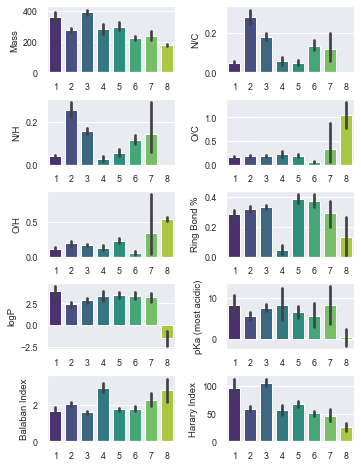

In [11]:
title = 'Observed'
data = cs_data_obs

for label in list(labels)[1:]:
    print(label)
    data.sort_values(label, inplace=True)
    filename = os.path.join(savepath, 'properties_%s_%s' % (label, title))
    filename = filename.replace(' ', '')
    danal.plot_bar_averages_multi(label, list(cs_data)[1:], data, cols=2, rows=5,
                                  fig_width=5.5, filename=filename)

ClassyFire Superclass


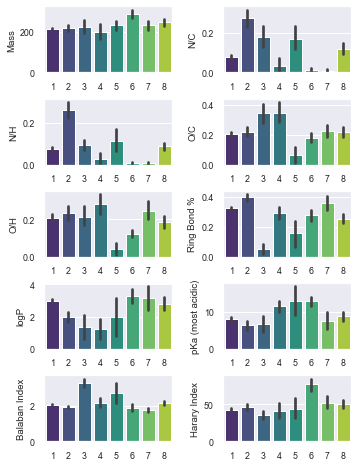

ChemSpace Cluster


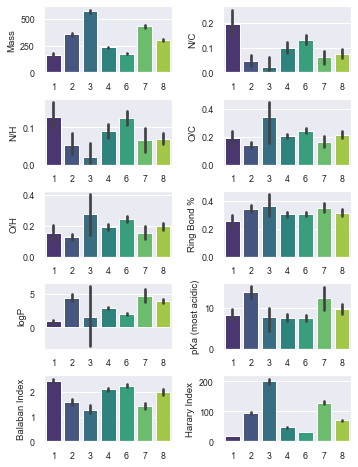

DarkChem Cluster


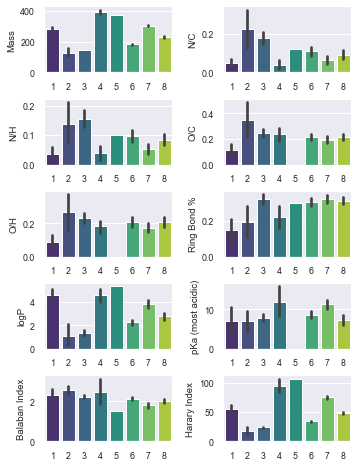

Substructure Cluster


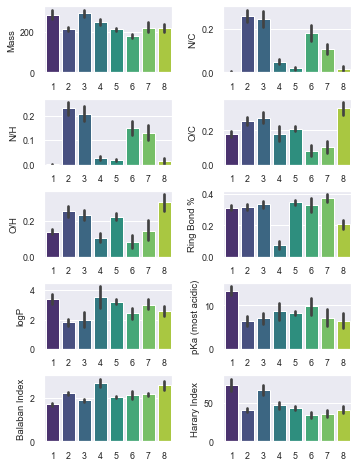

In [12]:
title = 'Not Observed'
data = cs_data_notobs

for label in list(labels)[1:]:
    print(label)
    data.sort_values(label, inplace=True)
    filename = os.path.join(savepath, 'properties_%s_%s' % (label, title))
    filename = filename.replace(' ', '')
    danal.plot_bar_averages_multi(label, list(cs_data)[1:], data, cols=2, rows=5,
                                  fig_width=5.5, filename=filename)

ClassyFire Superclass


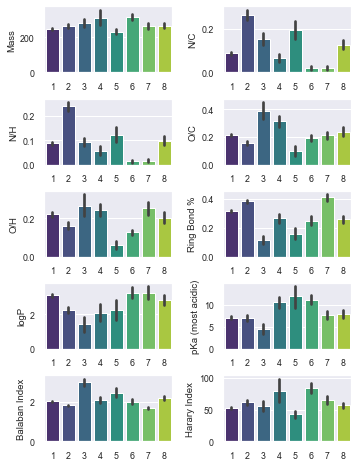

ChemSpace Cluster


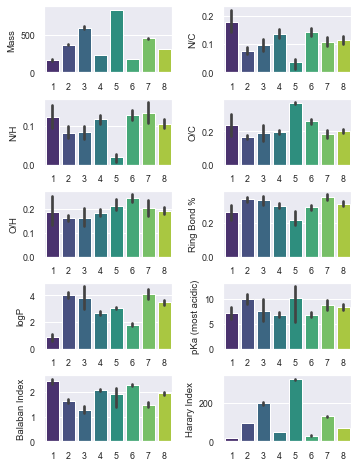

DarkChem Cluster


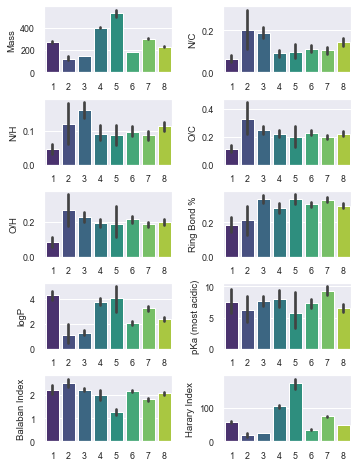

Substructure Cluster


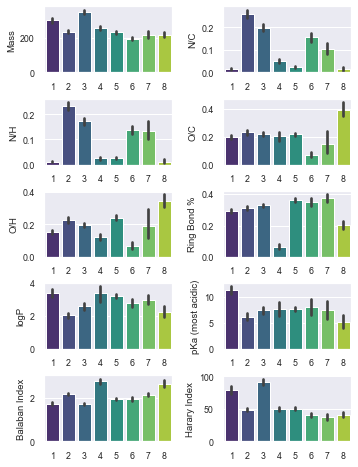

In [13]:
## Properties for spiked in compounds ##
title = 'Spiked In'
data = cs_data_spiked

for label in list(labels)[1:]:
    print(label)
    data.sort_values(label, inplace=True)
    filename = os.path.join(savepath, 'properties_%s_%s' % (label, title))
    filename = filename.replace(' ', '')
    danal.plot_bar_averages_multi(label, list(cs_data)[1:], data, cols=2, rows=5,
                                  fig_width=5.5, filename=filename)

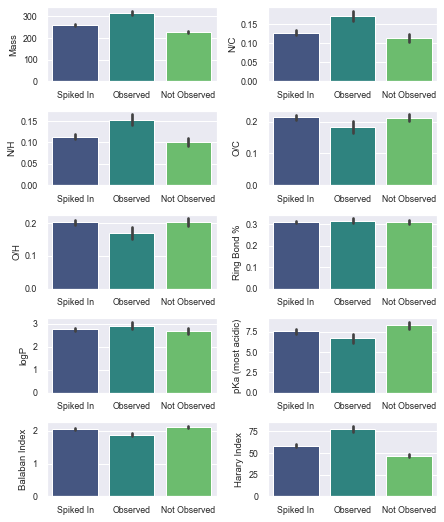

In [14]:
## Properties for spiked in/observed/not observed in general ##
label = 'Result'
cs_data_spiked[label] = 'Spiked In'
cs_data_obs[label] = 'Observed'
cs_data_notobs[label] = 'Not Observed'
cols = ['CpdInd', 'Mass', 'N/C', 'N/H', 'O/C', 'O/H', 'logP', 'pKa (most acidic)',
        'Balaban Index', 'Harary Index', 'Ring Bond %', label]
cs_data_combo = pd.concat([cs_data_spiked[cols], cs_data_obs[cols],
                           cs_data_notobs[cols]], sort=False)
del cs_data_spiked[label], cs_data_obs[label], cs_data_notobs[label]

filename = os.path.join(savepath, 'properties_%s' % (label)).replace(' ', '')
danal.plot_bar_averages_multi(label, list(cs_data)[1:], cs_data_combo,
                              fig_width=7, fig_height=9, wspace=0.3, cols=2, rows=5,
                              filename=filename)

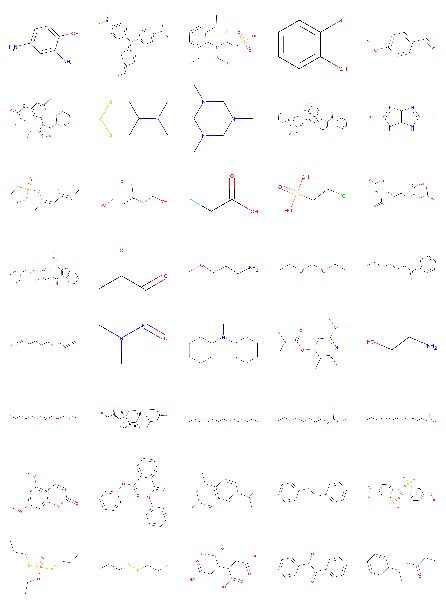

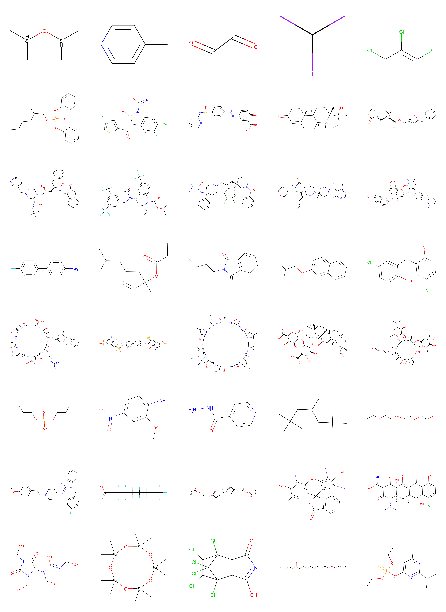

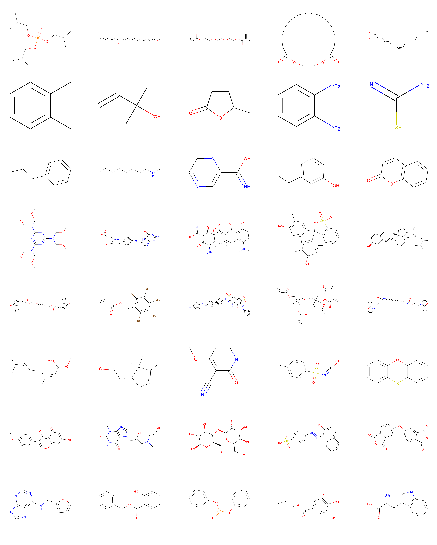

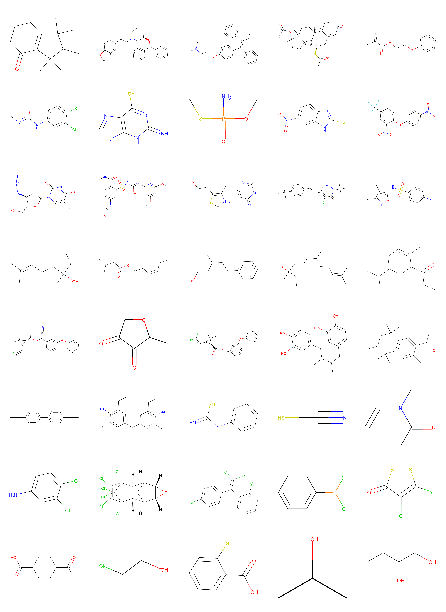

In [17]:
## Draw cluster representatives ##
n = 5  # Num representatives per group

cols = ['CpdInd', 'Uncharged, Desalted, Major Tautomer SMILES']
data_temp = pd.read_excel(fname,
                          sheet_name='SuspectLibrary', usecols=cols, header=0)
data = labels.join(data_temp.set_index('CpdInd'), on='CpdInd')

# Convert SMILES to RDKit Mols object
data['Mols'] = [Chem.MolFromSmiles(smi) for smi in data[cols[1]]]
data = data[~pd.isnull(data['Mols'])]  # Some fail in RDKit

for label in list(labels)[1:]:
    filename = os.path.join(savepath, 'chemdraw_%s.png' % (label))
    danal.draw_cpds(data, label, n=n, filename=filename)
